# Comparison of Methods for Importing bulk CSV data Into MySQL Using Python
### Find the Fastest Way to Import CSV Data Into MySQL Database Using Python

<i>Author: Mohammad Shahid<br>
<i>[Medium Profile](https://medium.com/analytics-vidhya/part-3-7-pandas-dataframe-to-postgresql-using-python-6590fda63f41)

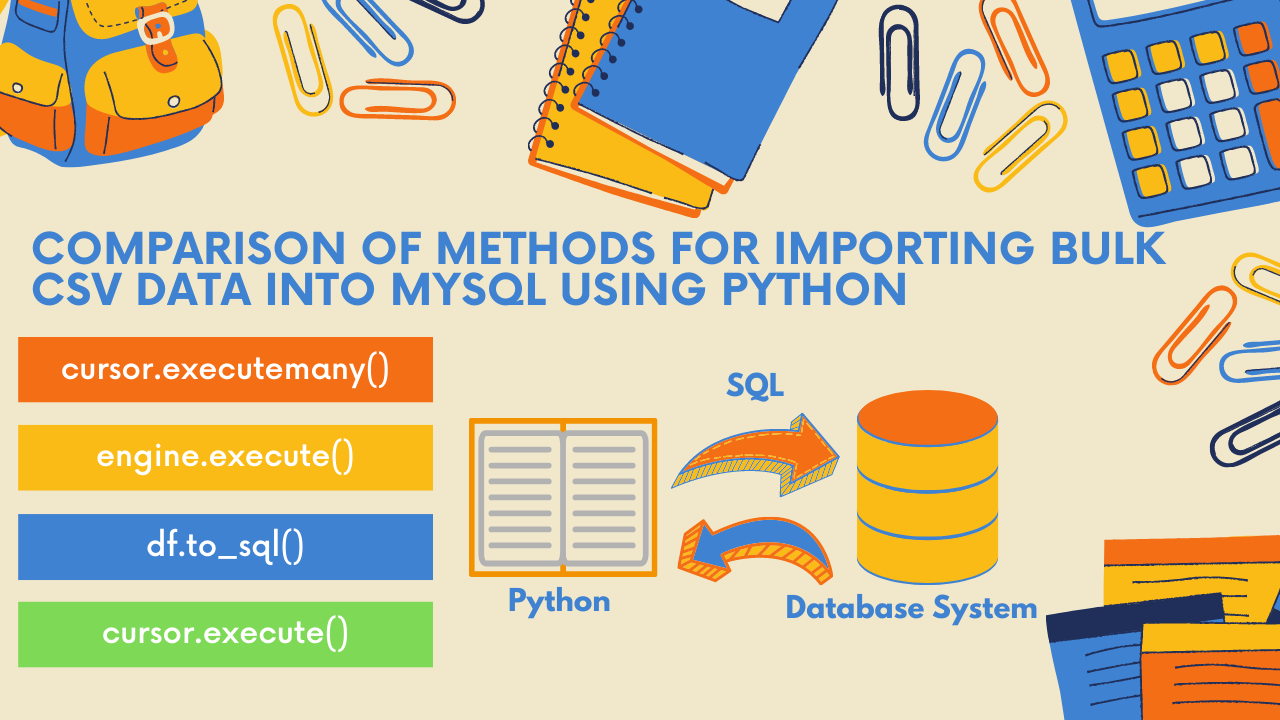

## Table of Contents
1. [**Overview**](#Overview)
2. [**Prerequisites**](#Prerequisites)
3. [**Prepare or Identify Your Data**](#Identify_Data)<br>
3.1 [Import libraries](#Import_libraries)<br>
3.2 [Extract the Data](#Extract_the_Data)<br>
3.3 [Create a Table in MySQL Database](#Create_Table)<br>
4. [**Measuring Time**](#Running_Time)<br>
5. [**Method**](#Methods)<br>
5.1 [Using single one by one insert](#Using_single_insertion)<br>
5.2 [Using execute_many()](#Using_execute_many())<br>
5.3 [Using_csv_reader()](#Using_csv_reader)<br>
5.4 [Using to_sql()](#Using_to_sql())<br> 
6. [**Results**](#Results)
7. [**Conclusion**](#Conclusion)


<a class="anchor" id="Overview"></a>
## 1. Overview
The main objective of this tutorial is to find the best method to import bulk CSV data into MySQL.

<a class="anchor" id="Prerequisites"></a>
## 2. Prerequisites
Python 3.8.3 : [Anaconda download link](https://www.anaconda.com/products/individual)<br>
MySQL 13 : [Download link](https://dev.mysql.com/downloads/installer/)<br>
sqlalchemy : To install sqlalchemy use the command: pip install sqlalchemy

<a class="anchor" id="Identify_Data"></a>
## 3. Prepare or Identify Your Data

To begin, prepare or identify the CSV file that you’d like to import to MySQL database. For example, we loaded iris data from GitHub.

<a class="anchor" id="Import_libraries"></a>
### 3.1 Import Libraries

In [121]:
import os
import sys
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as msql
from mysql.connector import Error
import csv

In [142]:
x = range(1,10000) 
x

range(1, 10000)

<a class="anchor" id="Extract_the_Data"></a>
### 3.2 Extract the Data

In [122]:
# Loading data from github
irisData = pd.read_csv('https://raw.githubusercontent.com/Muhd-Shahid/Learn-Python-Data-Access/main/iris.csv',index_col=False)
irisData.head()
df = irisData
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<a class="anchor" id="Create_Table"></a>
### 3.3 Create a Table in MySQL Database

To connect from Python to a MySQL database, we use sqlalchemy and mysql.connector:

##### Specify the connection parameters

In [123]:
# Note: please change your database, username & password as per your own values
conn_params_dic = {
    "host"      : "localhost",
    "database"  : "irisdb",
    "user"      : "root",
    "password"  : "sql@123"
}

##### Define function to establish connection mysql.connector

In [124]:
# Define a connect function for MySQL database server
def connect(conn_params_dic):
    conn = None
    try:
        print('Connecting to the MySQL...........')
        conn = msql.connect(**conn_params_dic)
        print("Connection successfully..................")
        
    except Error as err:
        print("Error while connecting to MySQL", err)      
        # set the connection to 'None' in case of error
        conn = None
    return conn

##### Define function to establish connection using Alchemy

In [125]:
# Using alchemy method
connect_alchemy = "mysql+pymysql://%s:%s@%s/%s" % (
    conn_params_dic['user'],
    conn_params_dic['password'],
    conn_params_dic['host'],
    conn_params_dic['database']
)

def using_alchemy():
    try:
        print('Connecting to the MySQL...........')
        engine = create_engine(connect_alchemy)
        print("Connection successfully..................")
    except Error as err:
        print("Error while connecting to MySQL", err)      
        # set the connection to 'None' in case of error
        engine = None
    return engine

##### Define function to create table

In [126]:
def create_table(engine):
    try:
        # Dropping table iris if exists
        engine.execute("DROP TABLE IF EXISTS iris;")
        sql = '''CREATE TABLE iris(
        sepal_length DECIMAL(2,1) NOT NULL, 
        sepal_width DECIMAL(2,1) NOT NULL, 
        petal_length DECIMAL(2,1) NOT NULL, 
        petal_width DECIMAL(2,1),
        species CHAR(11) NOT NULL
        )'''
        # Creating a table
        engine.execute(sql);
        print("iris table is created successfully................")  
    except Error as err:
        print("Error while connecting to MySQL", err)    
        # set the connection to 'None' in case of error
        conn = None

<a class="anchor" id="Running_Time"></a>
## 4. Running Time

For measuring execution time of each method, we used timeit.

In [127]:
# Example
def run_method(n):
    for i in range(n):
        3 ** n

In [128]:
from timeit import default_timer as timer
start_time = timer()
run_method(10000)
end_time = timer()
elapsed = end_time-start_time
print('function took {:.3f} ms'.format((elapsed)*1000.0))

function took 902.632 ms


<a class="anchor" id="Methods"></a>
## 5. Methods

<a class="anchor" id="Using_single_insertion"></a>
### 5.1. Using one by one inserts

To establish a baseline we start with the easiest methodology, insert records one by one:

In [146]:
def single_inserts(engine, df, table):
   # for i in df.index:
   #     cols  = ','.join(list(df.columns))
 #       vals  = [df.at[i,col] for col in list(df.columns)]
#        query = "INSERT INTO %s(%s) VALUES(%s,%s,%s,%s,'%s')" % (table, cols, vals[0], vals[1], vals[2],vals[3],vals[4])
 #       engine.execute(query)
    print("single_inserts() done")

<a class="anchor" id="Using_execute_many()"></a>
### 5.2. Using execute_many()

The mysql documentation : using [executemany](https://dev.mysql.com/doc/connector-python/en/connector-python-api-mysqlcursor-executemany.html) 

<blockquote>Execute a database operation (query or command) against all parameter tuples or mappings found in the sequence vars_list.</blockquote>

In [130]:
# Define function using cursor.executemany() to insert the dataframe
def execute_many(conn, datafrm, table):
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ','.join(list(datafrm.columns))
    
    # SQL query to execute
    sql = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        cursor.executemany(sql, tpls)
        conn.commit()
        print("Data inserted using execute_many() successfully...")
    except Error as e:
        print("Error while inserting to MySQL", e)
        cursor.close()

<a class="anchor" id="Using_csv_reader"></a>
### 5.3. Using_csv_reader()

In [148]:
def using_csv_reader(engine, datafrm, table_name):
    
    try:
        # Change your own path
        datafrm.to_csv('../Learn Python Data Access/iris_bulk.csv', index=False)
        # dataframe columns with Comma-separated
        cols = ','.join(list(datafrm.columns))
        # SQL query to execute
        sql = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s)" % (table_name, cols)
        sql = sql.format(table_name)
        # Change your own path
        with open('../Learn Python Data Access/iris_bulk.csv') as fh:
            reader = csv.reader(fh)
            next(reader)  # Skip firt line (headers)
            data = list(reader)
        engine.execute(sql, data)
        print("Data inserted using Using_csv_reader() successfully...")
    except Error as err:
        print("Error while inserting to MySQL", e)

<a class="anchor" id="Using_to_sql()"></a>
### 5.4. Using to_sql() (sqlalchemy)

In [132]:
def using_sqlalchemy(engine,datafrm,table):
    try:
        datafrm.to_sql(table, con=engine, index=False, if_exists='append',chunksize = 1000)
        print("Data inserted using to_sql()(sqlalchemy) done successfully...")
    except Error as err:
        print("Error while inserting to MySQL", e)

<a class="anchor" id="Results"></a>
### 6. Results

In [151]:
conn = connect(conn_params_dic)
engine = using_alchemy()
create_table(engine)

Connecting to the MySQL...........
Connection successfully..................
Connecting to the MySQL...........
Connection successfully..................
iris table is created successfully................


### Define a function to compare the performance of each method

Here, we are running only three methods execute_many, and using_csv_reader, using_sqlalchemy. As we know already single inserts will take more time compare to other three.

In [162]:
#-----------------------------------------
# COMPARE THE PERFORMANCE OF EACH METHOD
#-----------------------------------------
def compare_methods_to_insert_bulk_data(conn,engine,df):
    #execute_query(conn, "delete from iris where true;")
    # Delete records from iris table
    engine.execute("delete from iris where true;")
    print("Data has been deleted from iris table..........")
    print("")
    
    # Including single_inserts method
    #methods = [single_inserts, execute_many, using_csv_reader, using_sqlalchemy]
    # Excluding single_inserts method
    methods = [execute_many, using_csv_reader, using_sqlalchemy]
    
    df_performance = pd.DataFrame(index=range(len(methods)), columns=['Total_Records','Method_Name','Time ()'])

    k = 0
    for method in methods:
        start_time = timer()
        if method==execute_many:
            method(conn, df, 'iris')
        else:
            method(engine, df, 'iris')
        end_time = timer()
        
        df_performance.at[k,'Total_Records'] = len(df.index)
        df_performance.at[k,'Method_Name'] = method.__name__
        df_performance.at[k,'Time ()'] = end_time-start_time
        
        # Delete records for the previous method and prepare test for the next method
        engine.execute("delete from iris where true;")
        print("Data has been deleted from iris table........")
        print("")
        k = k + 1
   
    return df_performance

### Compare the performance of each method for 1000, 5000,10000, 50000,100000 rows.

In [165]:
df = irisData
# Repeating our dataframe 6667 times to get a large test dataframe
bulk_df = pd.concat([df]*6667, ignore_index=True)
# Saving on the disc
print(len(bulk_df.index))

1000050


In [166]:
df_performance_list = []

for records in [1000,5000,10000,50000,100000,1000000]:
    print("records = %s" % records)
    df_cutoff = bulk_df[0:records]
    df_performance = compare_methods_to_insert_bulk_data(conn,engine,df_cutoff)
    df_performance_list.append(df_performance)
    

method_performances = pd.concat(df_performance_list, axis=0).reset_index()
method_performances.head()

records = 1000
Data has been deleted from iris table..........

Data inserted using execute_many() successfully...
Data has been deleted from iris table........

Data inserted using Using_csv_reader() successfully...
Data has been deleted from iris table........

Data inserted using to_sql()(sqlalchemy) done successfully...
Data has been deleted from iris table........

records = 5000
Data has been deleted from iris table..........

Data inserted using execute_many() successfully...
Data has been deleted from iris table........

Data inserted using Using_csv_reader() successfully...
Data has been deleted from iris table........

Data inserted using to_sql()(sqlalchemy) done successfully...
Data has been deleted from iris table........

records = 10000
Data has been deleted from iris table..........

Data inserted using execute_many() successfully...
Data has been deleted from iris table........

Data inserted using Using_csv_reader() successfully...
Data has been deleted from iris tabl

,index,Total_Records,Method_Name,Time ()
0,0,1000,execute_many,0.39986
1,1,1000,using_csv_reader,0.556039
2,2,1000,using_sqlalchemy,0.561665
3,0,5000,execute_many,0.270969
4,1,5000,using_csv_reader,0.303024


In [169]:
method_performances
# Change your own path
method_performances.to_csv('../Learn Python Data Access/method_performance.csv', index=False)

### Visualize the performance of each method

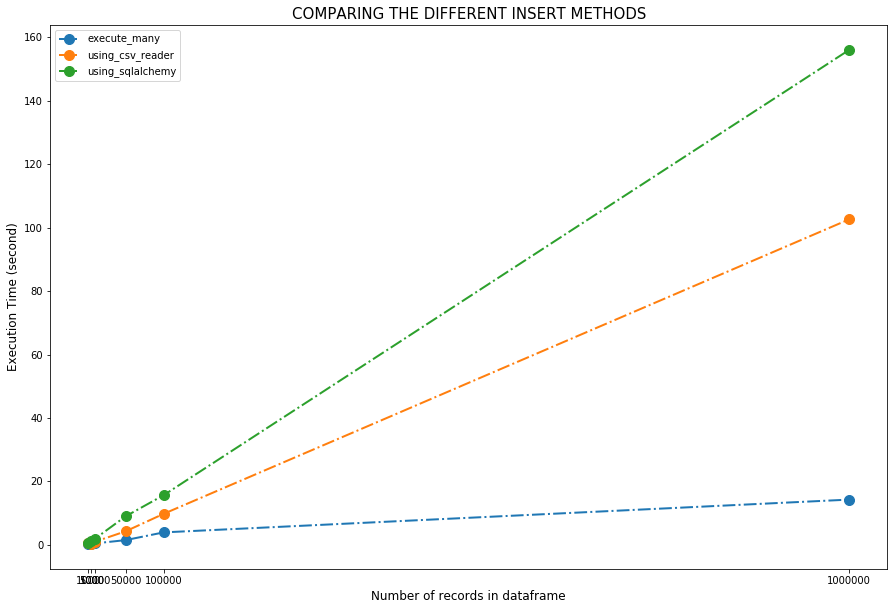

In [171]:
fig, ax = plt.subplots(figsize=(15,10))
for method in method_performances['Method_Name'].unique():
    subset = method_performances[method_performances['Method_Name'] == method]    
    ax.plot(subset['Total_Records'], subset['Time ()'], 'o-.', label=method, linewidth=2, markersize=10)

plt.xticks([1000, 5000,10000, 50000,100000,1000000])
plt.xlabel('Number of records in dataframe',fontsize=12)
plt.ylabel('Execution Time (second)',fontsize=12)
plt.title("COMPARING THE DIFFERENT INSERT METHODS", fontsize=15)
plt.legend()
# Change your own path
plt.savefig(".../Learn Python Data Access/all_methods.png", dpi=600)
plt.show()

In [ ]:
# Closing the cursor & connection
cursor.close()
conn.close()

<a class="anchor" id="Conclusion"></a>
### 7. Conclusion

Now, the main question is what should we use? the answer is it depends. Each method has its own advantages and disadvantages, and is suited for different circumstances. Here, we used very simple data with only five variables. Data can be complex , and system configuration can be different . As per our example, the fastest method is to use execute_many() however, using csv_reader() is also fine method to import the data.

### Medium Resources

### [How to import a CSV file into a MySQL database using Python](https://medium.com/python-in-plain-english/how-to-import-a-csv-file-into-a-mysql-database-using-python-script-791b051c5c33)
### [Comparison of Methods for Importing bulk CSV data Into MySQL Using Python](https://shahid-dhn.medium.com/comparison-of-methods-for-importing-bulk-csv-data-into-mysql-using-python-5890dbf57419)
### [Comparison of Methods for Importing bulk CSV data Into PostgreSQL Using Python](https://medium.com/analytics-vidhya/part-4-pandas-dataframe-to-postgresql-using-python-8ffdb0323c09)

### Stay Positive !! Stay Safe !! Keep Learning :):)

<h3>Thanks you for reading!!</h3>